In [1]:
import pandas as pd
import os
import numpy as np
import pandas_profiling

# This line is needed to display plots inline in Jupyter Notebook
%matplotlib inline

# Required for basic python plotting functionality
import matplotlib.pyplot as plt

# Required for formatting dates later in the case
import datetime
import matplotlib.dates as mdates

# Required to display image inline
from IPython.display import Image

# Advanced plotting functionality with seaborn
import seaborn as sns
sns.set(style="whitegrid") # can set style depending on how you'd like it to look

import folium  #needed for interactive map
from folium.plugins import HeatMap

import branca

import geopandas
from shapely.geometry import Polygon
from shapely.geometry import Point
from geopandas import GeoDataFrame

plotsize = (15,6)

In [19]:
path = 'Dataset/Parquets'
yellow_trips = pd.read_parquet(path + '/yellow_trips_filtered.parquet', engine = 'pyarrow')

### Maps

#### Heatmap

In [20]:
max_amount = float(yellow_trips['passenger_count'].max())

folium_hmap = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")

hm_wide = HeatMap( list(zip(yellow_trips['pickup_latitude'], yellow_trips['pickup_longitude'], 
                            yellow_trips['passenger_count'])),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=8, blur=6, 
                   max_zoom=15, 
                 )

folium_hmap.add_child(hm_wide);
path = 'Results'
folium_hmap.save(path + "/Maps/heatmap_yellow_trips.html")

In [21]:
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")

yellow_trips = yellow_trips.reset_index()

for i in range(0,1000):
    marker = folium.CircleMarker(location=[yellow_trips["pickup_latitude"][i],
                                           yellow_trips["pickup_longitude"][i]],
                                 radius=5,color="b",fill=True)
    marker.add_to(folium_map)

path = 'Results'
folium_map.save(path + "/Maps/markmap_yellow_trips.html")

### Trips graphs

In [22]:
path = 'Dataset/Parquets'
yellow_trips = pd.read_parquet(path + '/yellow_trips_nta.parquet', engine = 'pyarrow')

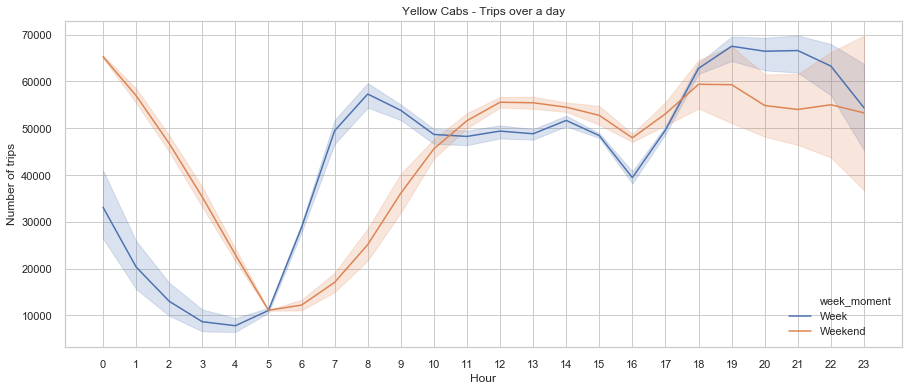

In [23]:
yellow_trips['pickup_hour'] = yellow_trips['pickup_datetime'].dt.hour
yellow_trips['pickup_weekday'] = yellow_trips['pickup_datetime'].dt.dayofweek
yellow_trips['week_moment'] = np.where(yellow_trips['pickup_weekday'] <= 4, 'Week', 'Weekend')
yellow_trips['pickup_weekday'] = np.where(yellow_trips['pickup_weekday'] == 0, 'Monday',
                                           np.where(yellow_trips['pickup_weekday'] == 1, 'Tuesday',
                                                   np.where(yellow_trips['pickup_weekday'] == 2, 'Wednesday',
                                                           np.where(yellow_trips['pickup_weekday'] == 3, 'Thursday',
                                                                   np.where(yellow_trips['pickup_weekday'] == 4, 'Friday',
                                                                           np.where(yellow_trips['pickup_weekday'] == 5, 'Saturday', 'Sunday'))))))

Trips_hour = yellow_trips.groupby(['pickup_hour', 'pickup_weekday', 'week_moment'])['pickup_longitude'].count().reset_index()
#Accidents_Hour['HOUR'] = Accidents_Hour['HOUR'].astype('str')

fig, ax = plt.subplots(figsize = plotsize)
m = sns.lineplot(x="pickup_hour", y="pickup_longitude", hue = 'week_moment', data=Trips_hour, ax=ax)
ax.set(xlabel='Hour', ylabel='Number of trips')
ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 18000)
plt.title('Yellow Cabs - Trips over a day');
path = 'Results'
plt.savefig(path + '/Images/yellow_trips_hour_week.png')

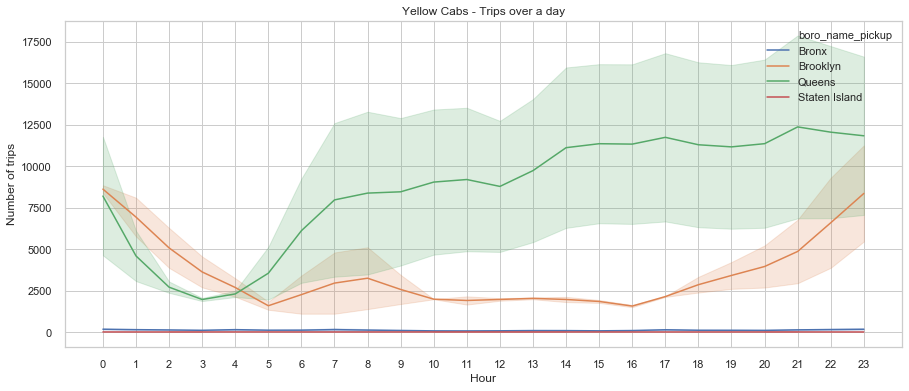

In [24]:
yellow_trips['pickup_hour'] = yellow_trips['pickup_datetime'].dt.hour
yellow_trips['pickup_weekday'] = yellow_trips['pickup_datetime'].dt.dayofweek
yellow_trips['week_moment'] = np.where(yellow_trips['pickup_weekday'] <= 4, 'Week', 'Weekend')
yellow_trips['pickup_weekday'] = np.where(yellow_trips['pickup_weekday'] == 0, 'Monday',
                                           np.where(yellow_trips['pickup_weekday'] == 1, 'Tuesday',
                                                   np.where(yellow_trips['pickup_weekday'] == 2, 'Wednesday',
                                                           np.where(yellow_trips['pickup_weekday'] == 3, 'Thursday',
                                                                   np.where(yellow_trips['pickup_weekday'] == 4, 'Friday',
                                                                           np.where(yellow_trips['pickup_weekday'] == 5, 'Saturday', 'Sunday'))))))

Trips_hour = yellow_trips.groupby(['pickup_hour', 'boro_name_pickup', 'week_moment'])['pickup_longitude'].count().reset_index()
#Accidents_Hour['HOUR'] = Accidents_Hour['HOUR'].astype('str')
Trips_hour = Trips_hour.loc[Trips_hour['boro_name_pickup'] != 'Manhattan']

fig, ax = plt.subplots(figsize = plotsize)
m = sns.lineplot(x="pickup_hour", y="pickup_longitude", hue = 'boro_name_pickup', data=Trips_hour, ax=ax)
ax.set(xlabel='Hour', ylabel='Number of trips')
ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 18000)
plt.title('Yellow Cabs - Trips over a day');
path = 'Results'
plt.savefig(path + '/Images/yellow_trips_hour_borough.png')

#### Boxplots

In [6]:
path = 'Dataset/Parquets'
yellow_trips = pd.read_parquet(path + '/yellow_trips_filtered.parquet', engine = 'pyarrow')

In [7]:
yellow_trips['pickup_month_dt'] = pd.to_datetime(yellow_trips['pickup_datetime']).dt.to_period('M')
yellow_trips['pickup_date'] = pd.to_datetime(yellow_trips['pickup_datetime']).dt.to_period('d')
yellow_trips['pickup_hour'] = pd.to_datetime(yellow_trips['pickup_datetime']).dt.hour
yellow_trips['pickup_weekday'] = yellow_trips['pickup_datetime'].dt.dayofweek
yellow_trips['weekend'] = np.where(yellow_trips['pickup_weekday'] <= 4, False, True)
yellow_trips['rush'] = np.where(((yellow_trips['pickup_hour'] >= 6) & (yellow_trips['pickup_hour'] <= 9)) |
                               ((yellow_trips['pickup_hour'] >= 15) & (yellow_trips['pickup_hour'] <= 20)), True, False)

In [9]:
yellow_trips_day = yellow_trips.groupby(['pickup_month_dt', 'pickup_date', 'weekend', 'rush'])['passenger_count'].count().reset_index(name = 'trips')
yellow_trips_day.head()

,pickup_month_dt,pickup_date,weekend,rush,trips
0,2014-04,2014-04-01,False,False,10442
1,2014-04,2014-04-01,False,True,11764
2,2014-04,2014-04-02,False,False,11331
3,2014-04,2014-04-02,False,True,11534
4,2014-04,2014-04-03,False,False,11863


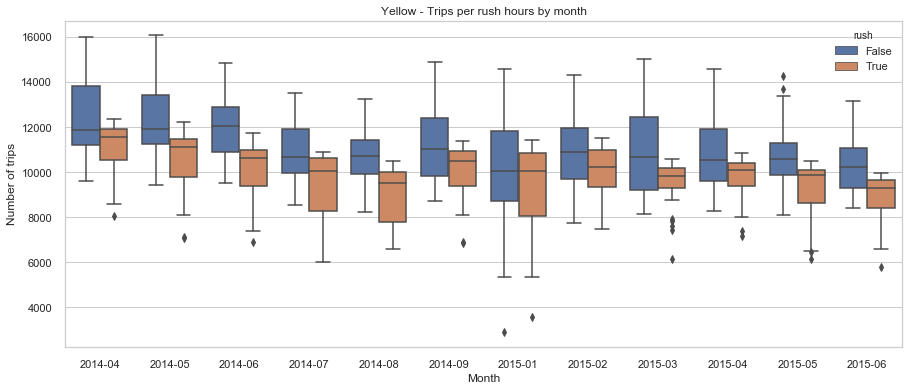

In [10]:
fig, ax = plt.subplots(figsize = plotsize)
m = sns.boxplot(x="pickup_month_dt", y="trips", hue = 'rush', data=yellow_trips_day, ax=ax)
ax.set(xlabel='Month', ylabel='Number of trips')
#ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 18000)
plt.title('Yellow - Trips per rush hours by month');
path = 'Results'
plt.savefig(path + '/Images/yellow_trips_month_rush.png')

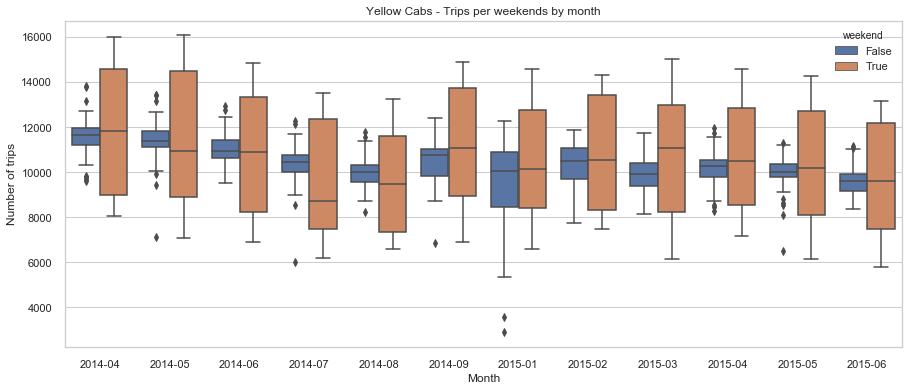

In [11]:
fig, ax = plt.subplots(figsize = plotsize)
m = sns.boxplot(x="pickup_month_dt", y="trips", hue = 'weekend', data=yellow_trips_day, ax=ax)
ax.set(xlabel='Month', ylabel='Number of trips')
#ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 18000)
plt.title('Yellow Cabs - Trips per weekends by month');
path = 'Results'
plt.savefig(path + '/Images/yellow_trips_month_weekend.png')

In [63]:
yellow_trips_day = yellow_trips.groupby(['pickup_month_dt', 'pickup_date'])['trip_distance'].mean().reset_index(name = 'avg_trip_distance')
yellow_trips_day.head()

,pickup_month_dt,pickup_date,avg_trip_distance
0,2014-04,2014-04-01,2.918699
1,2014-04,2014-04-02,2.918068
2,2014-04,2014-04-03,3.009486
3,2014-04,2014-04-04,2.903823
4,2014-04,2014-04-05,2.878695


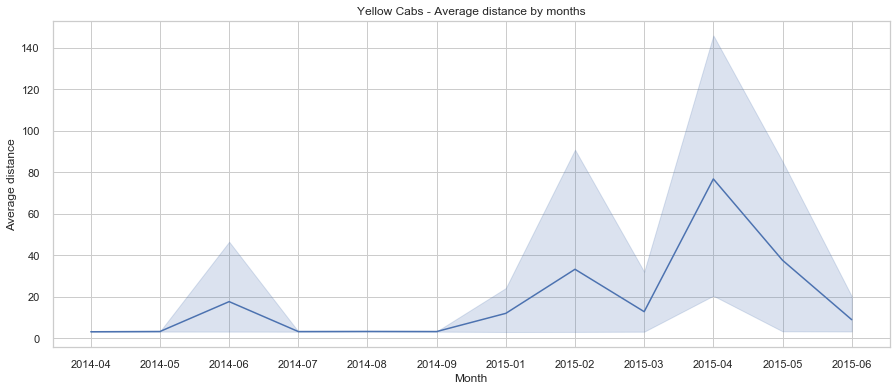

In [53]:
plot_base = yellow_trips_day.copy()
plot_base['pickup_month_dt'] = plot_base['pickup_month_dt'].astype('str')

fig, ax = plt.subplots(figsize = plotsize)
m = sns.lineplot(x="pickup_month_dt", y="avg_trip_distance", data=plot_base, ax=ax)
ax.set(xlabel='Month', ylabel='Average distance')
#ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 5)
plt.title('Yellow Cabs - Average distance by months');
path = 'Results'
plt.savefig(path + '/Images/yellow_avgdistance_month.png')

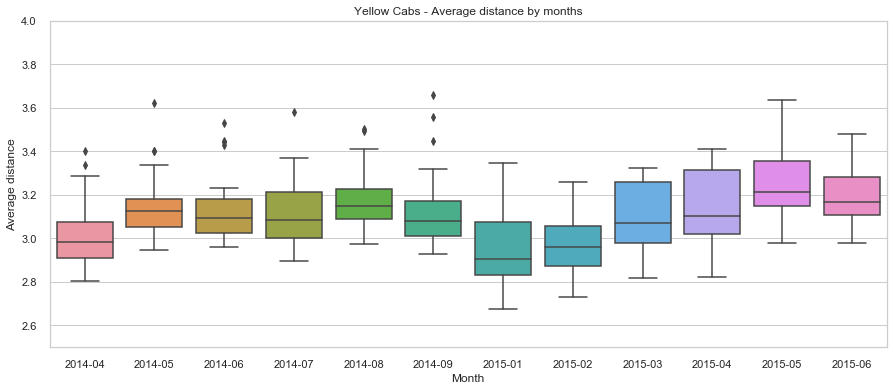

In [64]:
plot_base = yellow_trips_day.copy()
plot_base['pickup_month_dt'] = plot_base['pickup_month_dt'].astype('str')

fig, ax = plt.subplots(figsize = plotsize)
m = sns.boxplot(x="pickup_month_dt", y="avg_trip_distance", data=plot_base, ax=ax)
ax.set(xlabel='Month', ylabel='Average distance')
#ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
plt.ylim(2.5, 4)
plt.title('Yellow Cabs - Average distance by months');
path = 'Results'
plt.savefig(path + '/Images/yellow_avgdistance_month_boxplot.png')

In [57]:
yellow_trips.head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,total_amount,pickup_month,dropoff_month,amount_per_distance,pickup_month_dt,pickup_date,pickup_hour,pickup_weekday,weekend,rush
0,2014-04-03 18:28:10,2014-04-03 18:28:10,-74.006033,40.706284,-73.918837,40.744946,1,8.70,34.8,201404,201404,4.000000,2014-04,2014-04-03,18,3,False,True
1,2014-04-16 15:42:00,2014-04-16 15:42:00,-73.979558,40.749357,0.000000,0.000000,1,9.37,30.0,201404,201404,3.201708,2014-04,2014-04-16,15,2,False,True
2,2014-04-13 18:04:00,2014-04-13 18:04:00,-73.956453,40.775307,-73.954792,40.784992,1,0.89,6.5,201404,201404,7.303371,2014-04,2014-04-13,18,6,True,True
3,2014-05-21 19:33:00,2014-05-21 19:33:00,-73.987212,40.757850,-73.960198,40.775472,1,2.40,12.5,201405,201405,5.208333,2014-05,2014-05-21,19,2,False,True
4,2014-05-30 16:28:00,2014-05-30 16:28:00,-73.974292,40.755397,-74.011867,40.704222,3,5.58,24.5,201405,201405,4.390681,2014-05,2014-05-30,16,4,False,True


In [58]:
yellow_trips_day = yellow_trips.groupby(['pickup_month_dt', 'pickup_date'])['amount_per_distance'].mean().reset_index(name = 'avg_amount_per_distance')
yellow_trips_day.head()

,pickup_month_dt,pickup_date,avg_amount_per_distance
0,2014-04,2014-04-01,6.667176
1,2014-04,2014-04-02,6.825494
2,2014-04,2014-04-03,6.765979
3,2014-04,2014-04-04,6.795747
4,2014-04,2014-04-05,6.314361


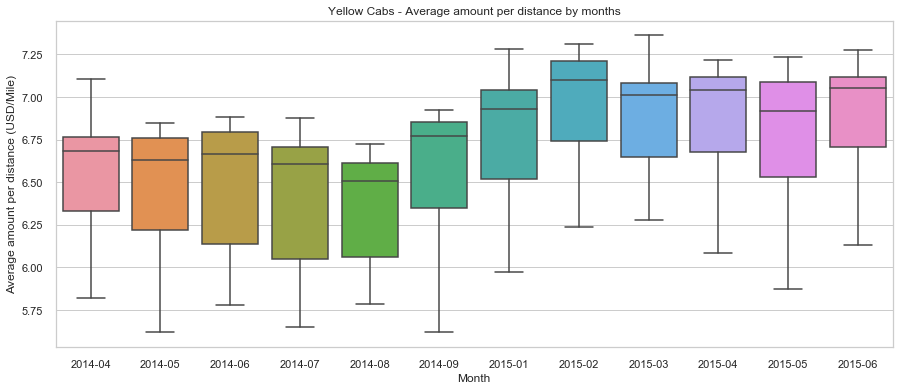

In [61]:
plot_base = yellow_trips_day.copy()
plot_base['pickup_month_dt'] = plot_base['pickup_month_dt'].astype('str')

fig, ax = plt.subplots(figsize = plotsize)
m = sns.boxplot(x="pickup_month_dt", y="avg_amount_per_distance", data=plot_base, ax=ax)
ax.set(xlabel='Month', ylabel='Average amount per distance (USD/Mile)')
#ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(2.5, 4)
plt.title('Yellow Cabs - Average amount per distance by months');
path = 'Results'
plt.savefig(path + '/Images/yellow_avgamountperdistance_month_boxplot.png')

In [65]:
yellow_trips_day = yellow_trips.groupby(['pickup_month_dt', 'pickup_date', 'rush'])['amount_per_distance'].mean().reset_index(name = 'avg_amount_per_distance')
yellow_trips_day.head()

,pickup_month_dt,pickup_date,rush,avg_amount_per_distance
0,2014-04,2014-04-01,False,6.400845
1,2014-04,2014-04-01,True,6.903577
2,2014-04,2014-04-02,False,6.602606
3,2014-04,2014-04-02,True,7.044459
4,2014-04,2014-04-03,False,6.565682


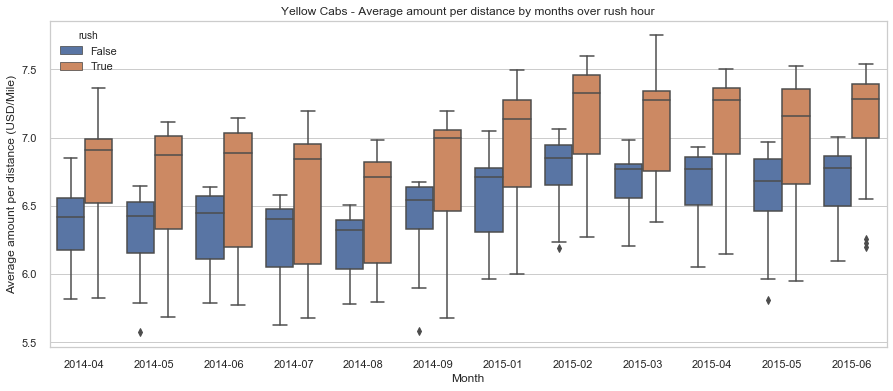

In [66]:
plot_base = yellow_trips_day.copy()
plot_base['pickup_month_dt'] = plot_base['pickup_month_dt'].astype('str')

fig, ax = plt.subplots(figsize = plotsize)
m = sns.boxplot(x="pickup_month_dt", y="avg_amount_per_distance", hue = 'rush', data=plot_base, ax=ax)
ax.set(xlabel='Month', ylabel='Average amount per distance (USD/Mile)')
#ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(2.5, 4)
plt.title('Yellow Cabs - Average amount per distance by months over rush hour');
path = 'Results'
plt.savefig(path + '/Images/yellow_avgamountperdistance_rush_month_boxplot.png')

In [67]:
yellow_trips_day = yellow_trips.groupby(['pickup_month_dt', 'pickup_date', 'weekend'])['amount_per_distance'].mean().reset_index(name = 'avg_amount_per_distance')
yellow_trips_day.head()

,pickup_month_dt,pickup_date,weekend,avg_amount_per_distance
0,2014-04,2014-04-01,False,6.667176
1,2014-04,2014-04-02,False,6.825494
2,2014-04,2014-04-03,False,6.765979
3,2014-04,2014-04-04,False,6.795747
4,2014-04,2014-04-05,True,6.314361


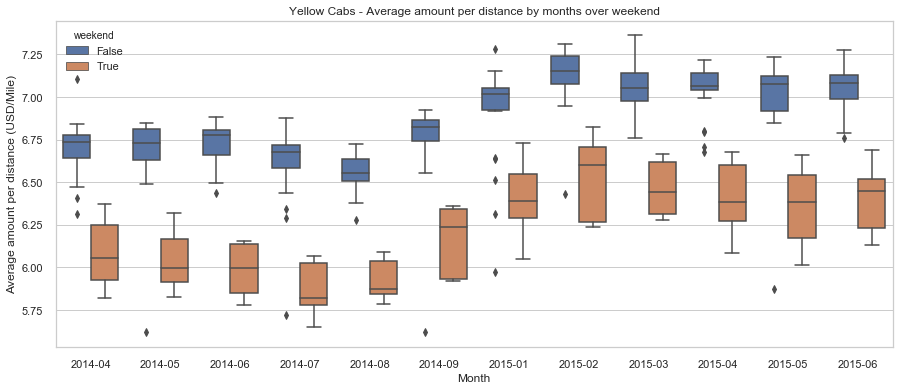

In [68]:
plot_base = yellow_trips_day.copy()
plot_base['pickup_month_dt'] = plot_base['pickup_month_dt'].astype('str')

fig, ax = plt.subplots(figsize = plotsize)
m = sns.boxplot(x="pickup_month_dt", y="avg_amount_per_distance", hue = 'weekend', data=plot_base, ax=ax)
ax.set(xlabel='Month', ylabel='Average amount per distance (USD/Mile)')
#ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(2.5, 4)
plt.title('Yellow Cabs - Average amount per distance by months over weekend');
path = 'Results'
plt.savefig(path + '/Images/yellow_avgamountperdistance_weekend_month_boxplot.png')

### Hipothesys testing

**Objective:** Compare the distance traveled between 201404 and 201406 with the one between 201504 and 201506

In [3]:
path = 'Dataset/Parquets'
yellow_trips = pd.read_parquet(path + '/yellow_trips_filtered.parquet', engine = 'pyarrow')
yellow_trips['pickup_month_dt'] = pd.to_datetime(yellow_trips['pickup_datetime']).dt.to_period('M')
yellow_trips['pickup_date'] = pd.to_datetime(yellow_trips['pickup_datetime']).dt.to_period('d')
yellow_trips['pickup_hour'] = pd.to_datetime(yellow_trips['pickup_datetime']).dt.hour
yellow_trips['pickup_weekday'] = yellow_trips['pickup_datetime'].dt.dayofweek
yellow_trips['weekend'] = np.where(yellow_trips['pickup_weekday'] <= 4, False, True)
yellow_trips['rush'] = np.where(((yellow_trips['pickup_hour'] >= 6) & (yellow_trips['pickup_hour'] <= 9)) |
                               ((yellow_trips['pickup_hour'] >= 15) & (yellow_trips['pickup_hour'] <= 20)), True, False)

In [4]:
yellow_trips.dtypes

pickup_datetime        datetime64[ns]
dropoff_datetime       datetime64[ns]
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
passenger_count                 int64
trip_distance                 float64
total_amount                  float64
pickup_month                    int64
dropoff_month                   int64
amount_per_distance           float64
pickup_month_dt             period[M]
pickup_date                 period[D]
pickup_hour                     int64
pickup_weekday                  int64
weekend                          bool
rush                             bool
dtype: object

In [5]:
yellow_trips.head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,total_amount,pickup_month,dropoff_month,amount_per_distance,pickup_month_dt,pickup_date,pickup_hour,pickup_weekday,weekend,rush
0,2014-04-03 18:28:10,2014-04-03 18:28:10,-74.006033,40.706284,-73.918837,40.744946,1,8.70,34.8,201404,201404,4.000000,2014-04,2014-04-03,18,3,False,True
1,2014-04-16 15:42:00,2014-04-16 15:42:00,-73.979558,40.749357,0.000000,0.000000,1,9.37,30.0,201404,201404,3.201708,2014-04,2014-04-16,15,2,False,True
2,2014-04-13 18:04:00,2014-04-13 18:04:00,-73.956453,40.775307,-73.954792,40.784992,1,0.89,6.5,201404,201404,7.303371,2014-04,2014-04-13,18,6,True,True
3,2014-05-21 19:33:00,2014-05-21 19:33:00,-73.987212,40.757850,-73.960198,40.775472,1,2.40,12.5,201405,201405,5.208333,2014-05,2014-05-21,19,2,False,True
4,2014-05-30 16:28:00,2014-05-30 16:28:00,-73.974292,40.755397,-74.011867,40.704222,3,5.58,24.5,201405,201405,4.390681,2014-05,2014-05-30,16,4,False,True


In [17]:
yellow_trips_201404_201406 = yellow_trips.loc[(yellow_trips['pickup_datetime'] >= '01/04/2014') & (yellow_trips['pickup_datetime'] <= '30/06/2014')]
yellow_trips_201504_201506 = yellow_trips.loc[(yellow_trips['pickup_datetime'] >= '01/04/2015') & (yellow_trips['pickup_datetime'] <= '30/06/2015')]

In [16]:
yellow_trips_201404_201406.pickup_datetime.min()
yellow_trips_201404_201406.pickup_datetime.max()

Timestamp('2014-06-30 00:00:00')

**Hypothesis:** The distance of the trips that took place between 2014-04 and 2014-06 is statistically similar with the ones between 2015-04 and 2015-06

$$H_0: \mu_1=\mu_2$$
$$H_a: \mu_1 \neq \mu_2$$

In [18]:
from scipy import stats
statistic, pvalue = stats.ttest_ind(yellow_trips_201404_201406.trip_distance, 
                                    yellow_trips_201504_201506.trip_distance, 
                                    equal_var=False)
statistic, pvalue

(-2.657604312557714, 0.007869848009439535)

**Conclusion:** There is enough statistical evidence to assert that the distance of the trips that took place between 2014-04 and 2014-06 is statistically **different** with the ones between 2015-04 and 2015-06

**Hypothesis:** The distance of the trips that took place in weekends is statistically similar with the ones in weekdays

$$H_0: \mu_1=\mu_2$$
$$H_a: \mu_1 \neq \mu_2$$

In [20]:
yellow_trips_weekend = yellow_trips.loc[(yellow_trips['weekend'] == True)]
yellow_trips_week = yellow_trips.loc[(yellow_trips['weekend'] == False)]

In [21]:
from scipy import stats
statistic, pvalue = stats.ttest_ind(yellow_trips_weekend.trip_distance, 
                                    yellow_trips_week.trip_distance, 
                                    equal_var=False)
statistic, pvalue

(1.3350062634806494, 0.18187440233398128)

**Conclusion:** There is enough statistical evidence to assert that the distance of the trips that took place in weekends is statistically **similar** with the ones in weekdays

**Hypothesis:** The distance of the trips that took place in rush hours is statistically similar with the ones in non-rush hours

$$H_0: \mu_1=\mu_2$$
$$H_a: \mu_1 \neq \mu_2$$

In [23]:
yellow_trips_rush = yellow_trips.loc[(yellow_trips['rush'] == True)]
yellow_trips_norush = yellow_trips.loc[(yellow_trips['rush'] == False)]

In [24]:
from scipy import stats
statistic, pvalue = stats.ttest_ind(yellow_trips_rush.trip_distance, 
                                    yellow_trips_norush.trip_distance, 
                                    equal_var=False)
statistic, pvalue

(0.11933507342401613, 0.9050099006701707)

**Conclusion:** There is enough statistical evidence to assert that the distance of the trips that took place in rush hours is statistically **similar** with the ones in non-rush hours

# Maps for NTA analysis

## Pick-up Analysis

In [37]:
path = 'Dataset/Parquets'
yellow_trips = pd.read_parquet(path + '/yellow_trips_nta.parquet', engine = 'pyarrow')

# Opens the map as a GeoDataFrame
path = 'Dataset/Original'
nyc_bouroughs = geopandas.read_file(path + '/Neighborhood Tabulation Areas.geojson')

In [38]:
yellow_trips_nta = yellow_trips.groupby('ntacode_pickup')['pickup_datetime'].count().reset_index(name = 'trips')
yellow_trips_nta.rename({'ntacode_pickup':'ntacode'}, inplace = True, axis = 1)

nyc_bouroughs_trips = nyc_bouroughs.merge(yellow_trips_nta, how = 'left', on = 'ntacode')
nyc_bouroughs_trips['trips'].fillna(0, inplace = True)
nyc_bouroughs_trips.head()

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,trips
0,BK88,54005018.7472,047,Borough Park,39247.2280737,Brooklyn,3,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",134.0
1,QN51,52488276.477,081,Murray Hill,33266.904811,Queens,4,"MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ...",57.0
2,QN27,19726845.26,081,East Elmhurst,19816.7115378,Queens,4,"MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ...",1484.0
3,QN07,22887772.7683,081,Hollis,20976.3358374,Queens,4,"MULTIPOLYGON (((-73.75726 40.71814, -73.75589 ...",11.0
4,MN06,10647077.6122,061,Manhattanville,17040.6865482,Manhattan,1,"MULTIPOLYGON (((-73.94608 40.82126, -73.94640 ...",7500.0


In [39]:
# interactive visualization for beat-specific crime rate in 2017

m_trips = folium.Map(location=[40.738, -73.98],
                        zoom_start=11,
                        tiles="OpenStreetMap")

colormap = branca.colormap.LinearColormap(
    colors=['white','yellow','orange','red','darkred'],
    #index=beat_cn['count'].quantile([0.2,0.4,0.6,0.8]),b
    vmin=nyc_bouroughs_trips.trips.min(),
    vmax=nyc_bouroughs_trips.trips.max()
)

style_function = lambda x: {
    'fillColor': colormap(x['properties']['trips']),
    'color': 'black',
    'weight':2,
    'fillOpacity':0.5
}

stategeo = folium.GeoJson(
    nyc_bouroughs_trips.to_json(),
    name='Chicago beats',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['ntaname', 'trips'],
        aliases=['NTA', 'Total trips'], 
        localize=True
    )
).add_to(m_trips)

colormap.add_to(m_trips)

path = 'Results'
m_trips.save(path + "/Maps/trips_nta_yellow_map.html")

In [40]:
# nta_code population
path = 'Dataset/Original'
demographics = pd.read_csv(path + '/demographics.csv', sep = ',', doublequote = True)

In [41]:
nyc_bouroughs_demo = nyc_bouroughs_trips.merge(demographics, how = 'left', 
                                               left_on = 'ntacode', right_on = 'nta_code')
nyc_bouroughs_demo.population.fillna(0, inplace = True)
nyc_bouroughs_demo.head()

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,trips,nta_name,...,15000_to_24999,25000_to_34999,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,mean_income
0,BK88,54005018.7472,047,Borough Park,39247.2280737,Brooklyn,3,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",134.0,Borough Park,...,4893.0,3850.0,3711.0,4098.0,2136.0,2486.0,1043.0,783.0,35754.0,55689.0
1,QN51,52488276.477,081,Murray Hill,33266.904811,Queens,4,"MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ...",57.0,Murray Hill,...,1665.0,2443.0,2151.0,2850.0,2140.0,2233.0,1031.0,906.0,52696.0,71925.0
2,QN27,19726845.26,081,East Elmhurst,19816.7115378,Queens,4,"MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ...",1484.0,East Elmhurst,...,617.0,730.0,1004.0,1173.0,860.0,766.0,295.0,128.0,51594.0,66284.0
3,QN07,22887772.7683,081,Hollis,20976.3358374,Queens,4,"MULTIPOLYGON (((-73.75726 40.71814, -73.75589 ...",11.0,Hollis,...,561.0,559.0,723.0,1204.0,655.0,1086.0,492.0,223.0,59368.0,75975.0
4,MN06,10647077.6122,061,Manhattanville,17040.6865482,Manhattan,1,"MULTIPOLYGON (((-73.94608 40.82126, -73.94640 ...",7500.0,Manhattanville,...,943.0,918.0,1303.0,917.0,599.0,421.0,168.0,79.0,29182.0,40748.0


In [42]:
nyc_bouroughs_demo['trips_population'] = np.where(nyc_bouroughs_demo['population'] == 0, 0, nyc_bouroughs_demo['trips']/nyc_bouroughs_demo['population'])

In [43]:
# interactive visualization for beat-specific crime rate in 2017

m_trips = folium.Map(location=[40.738, -73.98],
                        zoom_start=11,
                        tiles="OpenStreetMap")

colormap = branca.colormap.LinearColormap(
    colors=['white','yellow','orange','red','darkred'],
    #index=beat_cn['count'].quantile([0.2,0.4,0.6,0.8]),b
    vmin=nyc_bouroughs_demo.trips_population.min(),
    vmax=nyc_bouroughs_demo.trips_population.max()
)

style_function = lambda x: {
    'fillColor': colormap(x['properties']['trips_population']),
    'color': 'black',
    'weight':2,
    'fillOpacity':0.5
}

stategeo = folium.GeoJson(
    nyc_bouroughs_demo.to_json(),
    name='Chicago beats',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['boro_name', 'ntaname', 'trips_population'],
        aliases=['Borough', 'NTA', 'Total trips per population'], 
        localize=True
    )
).add_to(m_trips)

colormap.add_to(m_trips)

path = 'Results'
m_trips.save(path + "/Maps/trips_pop_nta_uber_map.html")

In [44]:
# nta_code population
path = 'Dataset/Original'
demographics = pd.read_csv(path + '/demographics.csv', sep = ',', doublequote = True)

In [45]:
nyc_bouroughs_demo = nyc_bouroughs_trips.merge(demographics, how = 'left', 
                                               left_on = 'ntacode', right_on = 'nta_code')
nyc_bouroughs_demo.population.fillna(0, inplace = True)
nyc_bouroughs_demo.head()

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,trips,nta_name,...,15000_to_24999,25000_to_34999,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,mean_income
0,BK88,54005018.7472,047,Borough Park,39247.2280737,Brooklyn,3,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",134.0,Borough Park,...,4893.0,3850.0,3711.0,4098.0,2136.0,2486.0,1043.0,783.0,35754.0,55689.0
1,QN51,52488276.477,081,Murray Hill,33266.904811,Queens,4,"MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ...",57.0,Murray Hill,...,1665.0,2443.0,2151.0,2850.0,2140.0,2233.0,1031.0,906.0,52696.0,71925.0
2,QN27,19726845.26,081,East Elmhurst,19816.7115378,Queens,4,"MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ...",1484.0,East Elmhurst,...,617.0,730.0,1004.0,1173.0,860.0,766.0,295.0,128.0,51594.0,66284.0
3,QN07,22887772.7683,081,Hollis,20976.3358374,Queens,4,"MULTIPOLYGON (((-73.75726 40.71814, -73.75589 ...",11.0,Hollis,...,561.0,559.0,723.0,1204.0,655.0,1086.0,492.0,223.0,59368.0,75975.0
4,MN06,10647077.6122,061,Manhattanville,17040.6865482,Manhattan,1,"MULTIPOLYGON (((-73.94608 40.82126, -73.94640 ...",7500.0,Manhattanville,...,943.0,918.0,1303.0,917.0,599.0,421.0,168.0,79.0,29182.0,40748.0


In [46]:
nyc_bouroughs_demo['trips_population'] = np.where(nyc_bouroughs_demo['population'] == 0, 0, nyc_bouroughs_demo['trips']/nyc_bouroughs_demo['population'])

In [47]:
# interactive visualization for beat-specific crime rate in 2017

m_trips = folium.Map(location=[40.738, -73.98],
                        zoom_start=11,
                        tiles="OpenStreetMap")

colormap = branca.colormap.LinearColormap(
    colors=['white','yellow','orange','red','darkred'],
    #index=beat_cn['count'].quantile([0.2,0.4,0.6,0.8]),b
    vmin=nyc_bouroughs_demo.trips_population.min(),
    vmax=nyc_bouroughs_demo.trips_population.max()
)

style_function = lambda x: {
    'fillColor': colormap(x['properties']['trips_population']),
    'color': 'black',
    'weight':2,
    'fillOpacity':0.5
}

stategeo = folium.GeoJson(
    nyc_bouroughs_demo.to_json(),
    name='Chicago beats',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['boro_name', 'ntaname', 'trips_population'],
        aliases=['Borough', 'NTA', 'Total trips per population'], 
        localize=True
    )
).add_to(m_trips)

colormap.add_to(m_trips)

path = 'Results'
m_trips.save(path + "/Maps/trips_pop_nta_yellow_map.html")

In [48]:
path = 'DataSet/Parquets'
nyc_bouroughs_demo_save = nyc_bouroughs_demo.copy()
nyc_bouroughs_demo_save.drop('geometry', axis = 1, inplace = True)
nyc_bouroughs_demo_save.to_parquet(path + '/nyc_bouroughs_trips_yellow.parquet', engine = 'pyarrow')

## Drop-off Analysis

In [49]:
yellow_trips_nta = yellow_trips.groupby('ntacode_dropoff')['dropoff_datetime'].count().reset_index(name = 'trips')
yellow_trips_nta.rename({'ntacode_dropoff':'ntacode'}, inplace = True, axis = 1)

nyc_bouroughs_trips = nyc_bouroughs.merge(yellow_trips_nta, how = 'left', on = 'ntacode')
nyc_bouroughs_trips['trips'].fillna(0, inplace = True)
nyc_bouroughs_trips.head()

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,trips
0,BK88,54005018.7472,047,Borough Park,39247.2280737,Brooklyn,3,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",1707.0
1,QN51,52488276.477,081,Murray Hill,33266.904811,Queens,4,"MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ...",1065.0
2,QN27,19726845.26,081,East Elmhurst,19816.7115378,Queens,4,"MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ...",3399.0
3,QN07,22887772.7683,081,Hollis,20976.3358374,Queens,4,"MULTIPOLYGON (((-73.75726 40.71814, -73.75589 ...",244.0
4,MN06,10647077.6122,061,Manhattanville,17040.6865482,Manhattan,1,"MULTIPOLYGON (((-73.94608 40.82126, -73.94640 ...",12387.0


In [50]:
# interactive visualization for beat-specific crime rate in 2017

m_trips = folium.Map(location=[40.738, -73.98],
                        zoom_start=11,
                        tiles="OpenStreetMap")

colormap = branca.colormap.LinearColormap(
    colors=['white','yellow','orange','red','darkred'],
    #index=beat_cn['count'].quantile([0.2,0.4,0.6,0.8]),b
    vmin=nyc_bouroughs_trips.trips.min(),
    vmax=nyc_bouroughs_trips.trips.max()
)

style_function = lambda x: {
    'fillColor': colormap(x['properties']['trips']),
    'color': 'black',
    'weight':2,
    'fillOpacity':0.5
}

stategeo = folium.GeoJson(
    nyc_bouroughs_trips.to_json(),
    name='Chicago beats',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['boro_name', 'ntaname', 'trips'],
        aliases=['Borough', 'NTA', 'Total trips'], 
        localize=True
    )
).add_to(m_trips)

colormap.add_to(m_trips)

path = 'Results'
m_trips.save(path + "/Maps/trips_nta_yellow_dropoff_map.html")

In [51]:
# nta_code population
path = 'Dataset/Original'
demographics = pd.read_csv(path + '/demographics.csv', sep = ',', doublequote = True)

In [52]:
nyc_bouroughs_demo = nyc_bouroughs_trips.merge(demographics, how = 'left', 
                                               left_on = 'ntacode', right_on = 'nta_code')
nyc_bouroughs_demo.population.fillna(0, inplace = True)
nyc_bouroughs_demo.head()

nyc_bouroughs_demo['trips_population'] = np.where(nyc_bouroughs_demo['population'] == 0, 0, nyc_bouroughs_demo['trips']/nyc_bouroughs_demo['population'])

In [53]:
path = 'DataSet/Parquets'
nyc_bouroughs_demo_save = nyc_bouroughs_demo.copy()
nyc_bouroughs_demo_save.drop('geometry', axis = 1, inplace = True)
nyc_bouroughs_demo_save.to_parquet(path + '/nyc_bouroughs_trips_yellow_dropoff.parquet', engine = 'pyarrow')